## Step 1: Imports

In [1]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_curve, auc, roc_auc_score

## Step 2: Global Configuration

In [2]:
DATA_ROOT = r"E:\InstruNet-AI\data\post_preprocessing\irmas_mono"

INPUT_SHAPE = (128, 126, 1)
NUM_CLASSES = 11

BATCH_SIZE = 128
EPOCHS = 50

## Step 3: Load Label Map

In [3]:
with open(r"E:\InstruNet-AI\data\splits\label_map.json", "r") as f:
    class_to_id = json.load(f)

id_to_class = {v: k for k, v in class_to_id.items()}

## Step 4: Data Loader

In [4]:
def load_split(split):
    X, y = [], []
    split_dir = os.path.join(DATA_ROOT, split)

    for cls in os.listdir(split_dir):
        cls_id = class_to_id[cls]
        cls_dir = os.path.join(split_dir, cls)

        for file in os.listdir(cls_dir):
            if file.endswith(".npy"):
                mel = np.load(os.path.join(cls_dir, file))
                mel = mel[..., np.newaxis]

                label = np.zeros(NUM_CLASSES)
                label[cls_id] = 1

                X.append(mel)
                y.append(label)

    return np.array(X), np.array(y)

## Step 5: Load Dataset Splits

In [5]:
X_train, y_train = load_split("train")
X_val, y_val     = load_split("val")
X_test, y_test   = load_split("test")

print(X_train.shape, y_train.shape)

(4692, 128, 126, 1) (4692, 11)


## Step 6: Class Weights

In [6]:
class_counts = y_train.sum(axis=0)
total_samples = y_train.shape[0]
num_classes = y_train.shape[1]

class_weights = {
    i: total_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
}

## Step 7: Regularized Model with L2 + Dropout Adjustment

In [7]:
def build_instrunet_l2_regularized():
    inputs = layers.Input(shape=INPUT_SHAPE)

    x = layers.Conv2D(32, (5,5), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (5,5), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (5,5), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (5,5), padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", kernel_regularizer=regularizers.l2(1e-4))(x)

    return models.Model(inputs, outputs)

## Step 8: Compile Model (Same Optimizer & LR)

In [8]:
model = build_instrunet_l2_regularized()

optimizer = optimizers.SGD(
    learning_rate=0.01,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 126, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 126, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 63, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 31, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 15, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,227 (4.12 MB)

 Trainable params: 1,080,267 (4.12 MB)

 Non-trainable params: 960 (3.75 KB)

## Step 9: Callbacks

In [9]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath="best_l2_regularized_model.h5",
        monitor="val_loss",
        save_best_only=True
    )
]

## Step 10: Model Training

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.5769 - loss: 0.7111

37/37 ━━━━━━━━━━━━━━━━━━━━ 245s 6s/step - binary_accuracy: 0.6568 - loss: 0.6785 - val_binary_accuracy: 0.9091 - val_loss: 0.6217 - learning_rate: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.8313 - loss: 0.5864

37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.8548 - loss: 0.5562 - val_binary_accuracy: 0.8355 - val_loss: 0.5250 - learning_rate: 0.0100
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9022 - loss: 0.4754

37/37 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - binary_accuracy: 0.9054 - loss: 0.4558 - val_binary_accuracy: 0.8418 - val_loss: 0.4534 - learning_rate: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9142 - loss: 0.3935

37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9142 - loss: 0.3804 - val_binary_accuracy: 0.8489 - val_loss: 0.4055 - learning_rate: 0.0100
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9155 - loss: 0.3410

37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9160 - loss: 0.3314 - val_binary_accuracy: 0.8726 - val_loss: 0.3811 - learning_rate: 0.0100
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - binary_accuracy: 0.9165 - loss: 0.3060

37/37 ━━━━━━━━━━━━━━━━━━━━ 286s 7s/step - binary_accuracy: 0.9169 - loss: 0.3008 - val_binary_accuracy: 0.8719 - val_loss: 0.3702 - learning_rate: 0.0100
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9182 - loss: 0.2835

37/37 ━━━━━━━━━━━━━━━━━━━━ 292s 7s/step - binary_accuracy: 0.9181 - loss: 0.2819 - val_binary_accuracy: 0.8968 - val_loss: 0.3549 - learning_rate: 0.0100
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9202 - loss: 0.2700

37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - binary_accuracy: 0.9202 - loss: 0.2679 - val_binary_accuracy: 0.9085 - val_loss: 0.3308 - learning_rate: 0.0100
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9213 - loss: 0.2599

37/37 ━━━━━━━━━━━━━━━━━━━━ 271s 7s/step - binary_accuracy: 0.9216 - loss: 0.2586 - val_binary_accuracy: 0.9072 - val_loss: 0.3226 - learning_rate: 0.0100
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9232 - loss: 0.2535

37/37 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - binary_accuracy: 0.9238 - loss: 0.2503 - val_binary_accuracy: 0.9114 - val_loss: 0.3016 - learning_rate: 0.0100
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9255 - loss: 0.2441

37/37 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step - binary_accuracy: 0.9258 - loss: 0.2440 - val_binary_accuracy: 0.9136 - val_loss: 0.2893 - learning_rate: 0.0100
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9258 - loss: 0.2415

37/37 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - binary_accuracy: 0.9273 - loss: 0.2389 - val_binary_accuracy: 0.9145 - val_loss: 0.2762 - learning_rate: 0.0100
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 267s 7s/step - binary_accuracy: 0.9285 - loss: 0.2334 - val_binary_accuracy: 0.9102 - val_loss: 0.2879 - learning_rate: 0.0100
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9306 - loss: 0.2271

37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.9303 - loss: 0.2275 - val_binary_accuracy: 0.9186 - val_loss: 0.2649 - learning_rate: 0.0100
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9319 - loss: 0.2243

37/37 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - binary_accuracy: 0.9317 - loss: 0.2236 - val_binary_accuracy: 0.9174 - val_loss: 0.2578 - learning_rate: 0.0100
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9326 - loss: 0.2213

37/37 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - binary_accuracy: 0.9331 - loss: 0.2198 - val_binary_accuracy: 0.9232 - val_loss: 0.2473 - learning_rate: 0.0100
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9353 - loss: 0.2171

37/37 ━━━━━━━━━━━━━━━━━━━━ 269s 7s/step - binary_accuracy: 0.9349 - loss: 0.2158 - val_binary_accuracy: 0.9245 - val_loss: 0.2456 - learning_rate: 0.0100
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 252s 7s/step - binary_accuracy: 0.9355 - loss: 0.2119 - val_binary_accuracy: 0.9254 - val_loss: 0.2457 - learning_rate: 0.0100
Epoch 19/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9391 - loss: 0.2077

37/37 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - binary_accuracy: 0.9381 - loss: 0.2074 - val_binary_accuracy: 0.9254 - val_loss: 0.2453 - learning_rate: 0.0100
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - binary_accuracy: 0.9395 - loss: 0.2029 - val_binary_accuracy: 0.9195 - val_loss: 0.2482 - learning_rate: 0.0100
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9394 - loss: 0.2006

37/37 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - binary_accuracy: 0.9399 - loss: 0.2002 - val_binary_accuracy: 0.9324 - val_loss: 0.2331 - learning_rate: 0.0100
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9427 - loss: 0.1925

37/37 ━━━━━━━━━━━━━━━━━━━━ 261s 7s/step - binary_accuracy: 0.9417 - loss: 0.1967 - val_binary_accuracy: 0.9323 - val_loss: 0.2255 - learning_rate: 0.0100
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 271s 7s/step - binary_accuracy: 0.9432 - loss: 0.1923 - val_binary_accuracy: 0.9265 - val_loss: 0.2508 - learning_rate: 0.0100
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 254s 7s/step - binary_accuracy: 0.9440 - loss: 0.1893 - val_binary_accuracy: 0.9287 - val_loss: 0.2346 - learning_rate: 0.0100
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 242s 7s/step - binary_accuracy: 0.9455 - loss: 0.1860 - val_binary_accuracy: 0.9291 - val_loss: 0.2311 - learning_rate: 0.0100
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9468 - loss: 0.1837

37/37 ━━━━━━━━━━━━━━━━━━━━ 250s 7s/step - binary_accuracy: 0.9469 - loss: 0.1829 - val_binary_accuracy: 0.9323 - val_loss: 0.2159 - learning_rate: 0.0100
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9472 - loss: 0.1800

37/37 ━━━━━━━━━━━━━━━━━━━━ 253s 7s/step - binary_accuracy: 0.9481 - loss: 0.1784 - val_binary_accuracy: 0.9369 - val_loss: 0.2063 - learning_rate: 0.0100
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - binary_accuracy: 0.9489 - loss: 0.1758 - val_binary_accuracy: 0.9308 - val_loss: 0.2216 - learning_rate: 0.0100
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - binary_accuracy: 0.9506 - loss: 0.1730 - val_binary_accuracy: 0.9269 - val_loss: 0.2274 - learning_rate: 0.0100
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - binary_accuracy: 0.9522 - loss: 0.1695 - val_binary_accuracy: 0.9339 - val_loss: 0.2107 - learning_rate: 0.0100
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9533 - loss: 0.1642

37/37 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - binary_accuracy: 0.9531 - loss: 0.1664 - val_binary_accuracy: 0.9351 - val_loss: 0.2055 - learning_rate: 0.0100
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - binary_accuracy: 0.9541 - loss: 0.1629 - val_binary_accuracy: 0.9329 - val_loss: 0.2135 - learning_rate: 0.0100
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - binary_accuracy: 0.9548 - loss: 0.1607 - val_binary_accuracy: 0.9344 - val_loss: 0.2100 - learning_rate: 0.0100
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - binary_accuracy: 0.9563 - loss: 0.1563 - val_binary_accuracy: 0.9313 - val_loss: 0.2205 - learning_rate: 0.0100
Epoch 35/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - binary_accuracy: 0.9581 - loss: 0.1538 - val_binary_accuracy: 0.9317 - val_loss: 0.2127 - learning_rate: 0.0100
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9598 - loss: 0.1484

37/37 ━━━━━━━━━━━━━━━━━━━━ 265s 7s/step - binary_accuracy: 0.9593 - loss: 0.1497 - val_binary_accuracy: 0.9395 - val_loss: 0.2021 - learning_rate: 0.0100
Epoch 37/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9602 - loss: 0.1471 - val_binary_accuracy: 0.9374 - val_loss: 0.2119 - learning_rate: 0.0100
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - binary_accuracy: 0.9623 - loss: 0.1426 - val_binary_accuracy: 0.9287 - val_loss: 0.2279 - learning_rate: 0.0100
Epoch 39/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - binary_accuracy: 0.9632 - loss: 0.1397 - val_binary_accuracy: 0.9301 - val_loss: 0.2286 - learning_rate: 0.0100
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - binary_accuracy: 0.9654 - loss: 0.1360 - val_binary_accuracy: 0.9276 - val_loss: 0.2223 - learning_rate: 0.0100
Epoch 41/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 249s 7s/step - binary_accuracy: 0.9661 - loss: 0.1333 - val_binary_accuracy: 0.9380 - val_loss: 0.2029 - learning_rate: 0.0100
Epoch 42/50
37/3

37/37 ━━━━━━━━━━━━━━━━━━━━ 255s 7s/step - binary_accuracy: 0.9684 - loss: 0.1278 - val_binary_accuracy: 0.9402 - val_loss: 0.1984 - learning_rate: 0.0050
Epoch 43/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9717 - loss: 0.1226

37/37 ━━━━━━━━━━━━━━━━━━━━ 267s 7s/step - binary_accuracy: 0.9709 - loss: 0.1238 - val_binary_accuracy: 0.9417 - val_loss: 0.1913 - learning_rate: 0.0050
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.9719 - loss: 0.1211 - val_binary_accuracy: 0.9400 - val_loss: 0.1974 - learning_rate: 0.0050
Epoch 45/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 264s 7s/step - binary_accuracy: 0.9717 - loss: 0.1199 - val_binary_accuracy: 0.9369 - val_loss: 0.2012 - learning_rate: 0.0050
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step - binary_accuracy: 0.9734 - loss: 0.1170 - val_binary_accuracy: 0.9396 - val_loss: 0.1932 - learning_rate: 0.0050
Epoch 47/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9746 - loss: 0.1154 - val_binary_accuracy: 0.9373 - val_loss: 0.2012 - learning_rate: 0.0050
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - binary_accuracy: 0.9750 - loss: 0.1142 - val_binary_accuracy: 0.9381 - val_loss: 0.2044 - learning_rate: 0.0050
Epoch 49/50
37/3

37/37 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - binary_accuracy: 0.9763 - loss: 0.1100 - val_binary_accuracy: 0.9422 - val_loss: 0.1856 - learning_rate: 0.0025
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - binary_accuracy: 0.9780 - loss: 0.1091

37/37 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - binary_accuracy: 0.9785 - loss: 0.1084 - val_binary_accuracy: 0.9424 - val_loss: 0.1850 - learning_rate: 0.0025


## Step 11: Training vs Validation Accuracy Curves

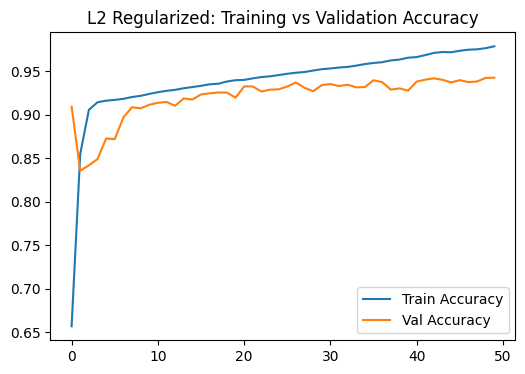

In [11]:
plt.figure(figsize=(6,4))
plt.plot(history.history["binary_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_binary_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("L2 Regularized: Training vs Validation Accuracy")
plt.show()

## Step 12: Training vs Validation Loss Curves

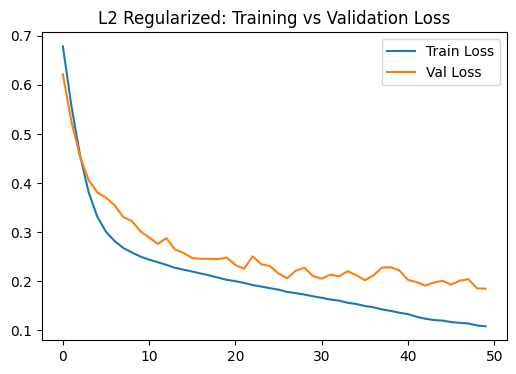

In [12]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("L2 Regularized: Training vs Validation Loss")
plt.show()

## Step 13: Test Set Evaluation

In [13]:
y_prob = model.predict(X_test)

THRESHOLD = 0.3
y_pred = (y_prob >= THRESHOLD).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step


## Step 14: Global Metrics

In [14]:
micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("Micro F1-score :", round(micro_f1, 4))
print("Macro F1-score :", round(macro_f1, 4))

Micro F1-score : 0.6765
Macro F1-score : 0.6573


## Step 15: Per-Class Precision & Recall

In [15]:
recalls = recall_score(y_test, y_pred, average=None)
precisions = precision_score(y_test, y_pred, average=None, zero_division=0)

for i in range(NUM_CLASSES):
    print(
        f"{id_to_class[i]} | "
        f"Recall: {recalls[i]:.3f} | "
        f"Precision: {precisions[i]:.3f}"
    )

cel | Recall: 0.638 | Precision: 0.712
cla | Recall: 0.487 | Precision: 0.712
flu | Recall: 0.500 | Precision: 0.680
gac | Recall: 0.758 | Precision: 0.750
gel | Recall: 0.588 | Precision: 0.677
org | Recall: 0.777 | Precision: 0.748
pia | Recall: 0.769 | Precision: 0.776
sax | Recall: 0.340 | Precision: 0.744
tru | Recall: 0.593 | Precision: 0.718
vio | Recall: 0.517 | Precision: 0.511
voi | Recall: 0.880 | Precision: 0.831


## Step 16: Confusion Matrices

In [16]:
for i in range(NUM_CLASSES):
    print(f"\nConfusion Matrix for {id_to_class[i]}")
    print(confusion_matrix(y_test[:, i], y_pred[:, i]))


Confusion Matrix for cel
[[933  15]
 [ 21  37]]

Confusion Matrix for cla
[[915  15]
 [ 39  37]]

Confusion Matrix for flu
[[922  16]
 [ 34  34]]

Confusion Matrix for gac
[[887  24]
 [ 23  72]]

Confusion Matrix for gel
[[860  32]
 [ 47  67]]

Confusion Matrix for org
[[876  27]
 [ 23  80]]

Confusion Matrix for pia
[[874  24]
 [ 25  83]]

Confusion Matrix for sax
[[901  11]
 [ 62  32]]

Confusion Matrix for tru
[[900  20]
 [ 35  51]]

Confusion Matrix for vio
[[876  43]
 [ 42  45]]

Confusion Matrix for voi
[[868  21]
 [ 14 103]]


## Step 17: ROC Curves

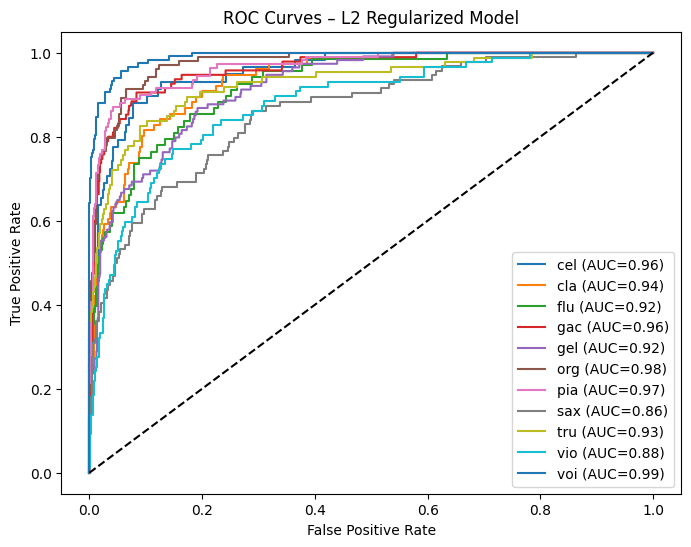

In [17]:
plt.figure(figsize=(8,6))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id_to_class[i]} (AUC={auc_score:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – L2 Regularized Model")
plt.legend()
plt.show()

## Step 18: Micro & Macro ROC–AUC

In [18]:
print("Micro ROC–AUC :", roc_auc_score(y_test, y_prob, average="micro"))
print("Macro ROC–AUC :", roc_auc_score(y_test, y_prob, average="macro"))

Micro ROC–AUC : 0.9432094312850532
Macro ROC–AUC : 0.9356820757798608
